<p align="right">
    <img src="Zewail-City.png">
</p>


---

# __Experiment (XII): Milky WayGalaxy’s Spectral Types & Stellar Distribution__


In [2]:
# Importing Main Librarires
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from astroquery.simbad import Simbad
from astropy import units as u
import astropy.coordinates as coord
from astropy.table import QTable, Column

## Task 1 Querying SIMBAD:

In [4]:
# Listing all the tables in the SIMBAD database
Simbad.list_tables()

table_name,description
object,object
basic,General data about an astronomical object
ids,all names concatenated with pipe
alltypes,all object types concatenated with pipe
ident,Identifiers of an astronomical object
cat,Catalogues name
flux,Magnitude/Flux information about an astronomical object
allfluxes,"all flux/magnitudes U,B,V,I,J,H,K,u_,g_,r_,i_,z_"
filter,Description of a flux filter
has_ref,Associations between astronomical objects and their bibliographic references


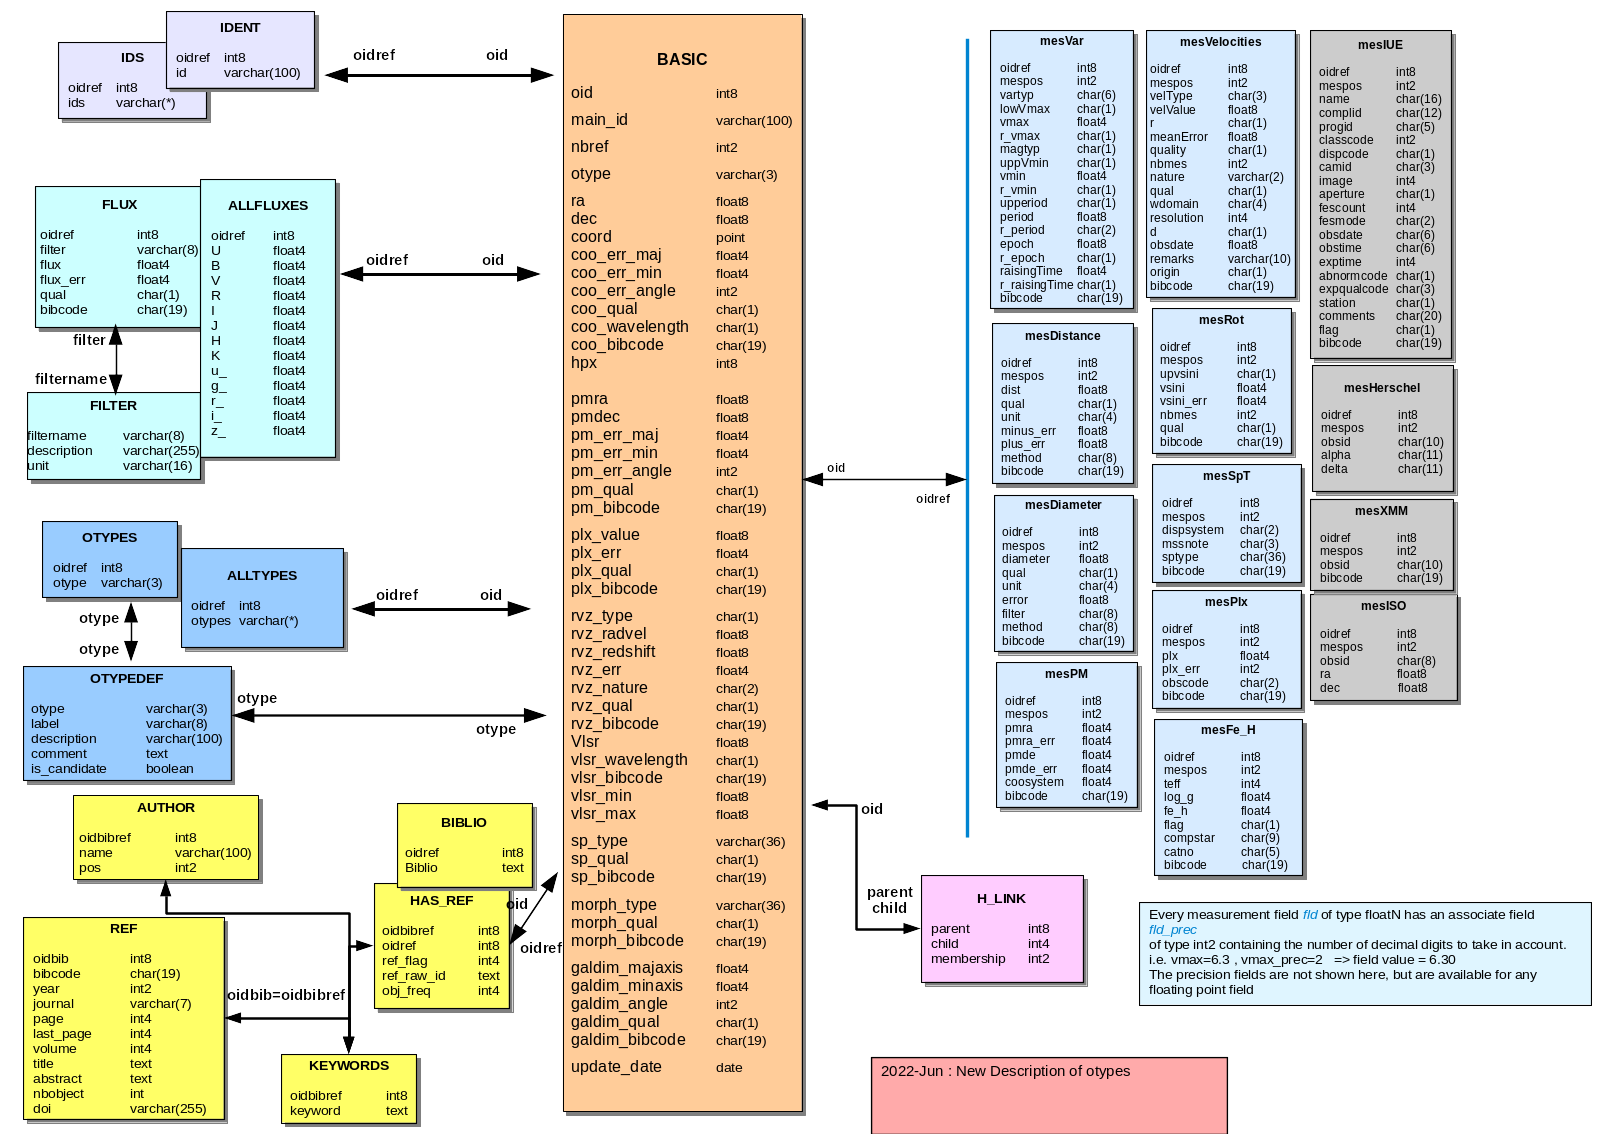

In [5]:
#SIMBAD Tables
from IPython.display import Image 
Image('https://simbad.u-strasbg.fr/simbad/images/tables.png')

In [6]:
# Constants for the North Galactic Pole 
alpha_P = 192.9 * np.pi / 180  # Right ascension in radians
delta_P = 27.1 * np.pi / 180   # Declination in radians
l_P = 122.9 * np.pi / 180      # Galactic longitude in radians
# Galactic-Equatorial Coordinates Conversion

def equatorial_to_galactic(alpha, delta):
    # Convert input coordinates to radians
    alpha = np.radians(alpha)
    delta = np.radians(delta)
    
    # Equation for sin(b)
    sin_b = (np.sin(delta_P) * np.sin(delta) +
             np.cos(delta_P) * np.cos(delta) * np.cos(alpha - alpha_P))
    
    # Equation for tan(l - l_P)
    numerator = np.cos(delta) * np.sin(alpha - alpha_P)
    denominator = (np.sin(delta_P) * np.cos(delta) -
                   np.cos(delta_P) * np.sin(delta) * np.cos(alpha - alpha_P))
    
    # Compute b and l
    b = np.arcsin(sin_b)  # Galactic latitude in radians
    l = np.arctan2(numerator, denominator) + l_P  # Galactic longitude in radians
    
    # Ensure l is within [0, 2π]
    l = np.mod(l, 2 * np.pi)
    
    # Convert back to degrees
    l = np.degrees(l)
    b = np.degrees(b)
    
    return l, b

In [7]:
# List of Stars from Appendix A
stars = [
    'Alpha1 Centaurus', 'Alpha Auriga', 'Beta Cetus', 'Beta Corvus', 'Eta Bootes',
    'Eta Draco', 'Beta Hercules', 'Beta Draco', 'Zeta Hercules', 'Epsilon Virgo',
    'Beta Lepus', 'Beta Aquarius', 'Gamma Perseus', 'Eta Pegasus', 'Alpha Aquarius',
    'Epsilon Leo', 'Gamma Hydra', 'Epsilon Gemini', 'Delta Draco', 'Zeta Hydra',
    'Zeta Cygnus', 'Epsilon Ophiuchus', 'Zeta Orion', 'Delta Orion', 'Zeta Puppis',
    'Zeta Ophiuchus', 'Iota Orion', 'Lambda Orion', 'Xi Perseus', 'Sigma Orion',
    'Alpha Camelopard', 'Tau Canis Major', '10 Lacerta', '29 Canis Major',
    '68 Cygnus', 'Delta Circinus', 'Lamda Cepheus', '19 Cepheus', '14 Cepheus',
    '9 Sagittarius', '9 Sagitta', '15 Monoceros', 'Theta2 Orion'
]

# Convert the list of stars into a string for the query
string_text = "', '".join(stars)
string_text = f"'{string_text}'"

# Base Query
query_base = """
SELECT
  main_id, ra, dec, V AS m_v, sp_type
FROM basic
JOIN ident ON ident.oidref = oid
JOIN allfluxes ON allfluxes.oidref = oid
WHERE id IN ({string_placeholder})
"""
query = query_base.format(string_placeholder=string_text)

# Execute query
tap_result = Simbad.query_tap(query)
df = tap_result.to_pandas()

# Drop rows with missing coordinates or spectral types
df.dropna(subset=['ra', 'dec', 'sp_type'], inplace=True)

# Add galactic coordinates
df['l'], df['b'] = equatorial_to_galactic(df['ra'], df['dec'])

In [8]:
# Corresponding M_v (absolute magnitudes) for the stars
M_v = [
    -6.99, -5.05, -2.71, -5.22, 0.32, -6.06, -5.11, -6.7, -3.88, -0.51, -7.39,
    4.45, -3.47, -0.34, -0.51, -2.47, -0.53, -0.64, -6.46, 0.61, -4.84, -1.48,
    -4.16, 0.61, 0.37, 2.38, 0.5, -1.19, -0.09, -1.58, -5.3, -4.73, -3.47,
    -4.05, -3.75, -5.11, -0.57, -0.13, 2.68, -0.22, -3.24, -5.15, -5.96
]

# Add the corresponding absolute magnitudes (M_v) to the DataFrame
df['M_v'] = M_v

# Calculate the distance in parsecs using the formula: d_pc = 10 * 10^(0.2 * (m_v - M_v))
df['d_pc'] = 10 * 10**(0.2 * (df['m_v'] - df['M_v'])) 

# Display Dataframe info
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 43 entries, 0 to 42
Data columns (total 9 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   main_id  43 non-null     object 
 1   ra       43 non-null     float64
 2   dec      43 non-null     float64
 3   m_v      43 non-null     float64
 4   sp_type  43 non-null     object 
 5   l        43 non-null     float64
 6   b        43 non-null     float64
 7   M_v      43 non-null     float64
 8   d_pc     43 non-null     float64
dtypes: float64(7), object(2)
memory usage: 3.2+ KB


In [9]:
#Displaying the dataframe 
df.head()

,main_id,ra,dec,m_v,sp_type,l,b,M_v,d_pc
0,* 9 Sge,298.090687,18.671875,6.230,O7.5Iabf,183.925803,-4.309580,-6.99,4405.548674
1,* 9 Sgr,270.968521,-24.360731,5.970,O4V((f))z,184.054983,-1.160042,-5.05,1599.557874
2,* 10 Lac,339.815328,39.050270,4.880,O9V,150.133682,-16.992695,-2.71,329.609730
3,* 14 Cep,330.519053,58.000364,5.542,O9IV(n)var+B1:V:,146.985296,2.169949,-5.22,1420.365004
4,* 15 Mon,100.244415,9.895756,4.680,O7V+B1.5/2V,57.755351,2.158063,0.32,74.473192


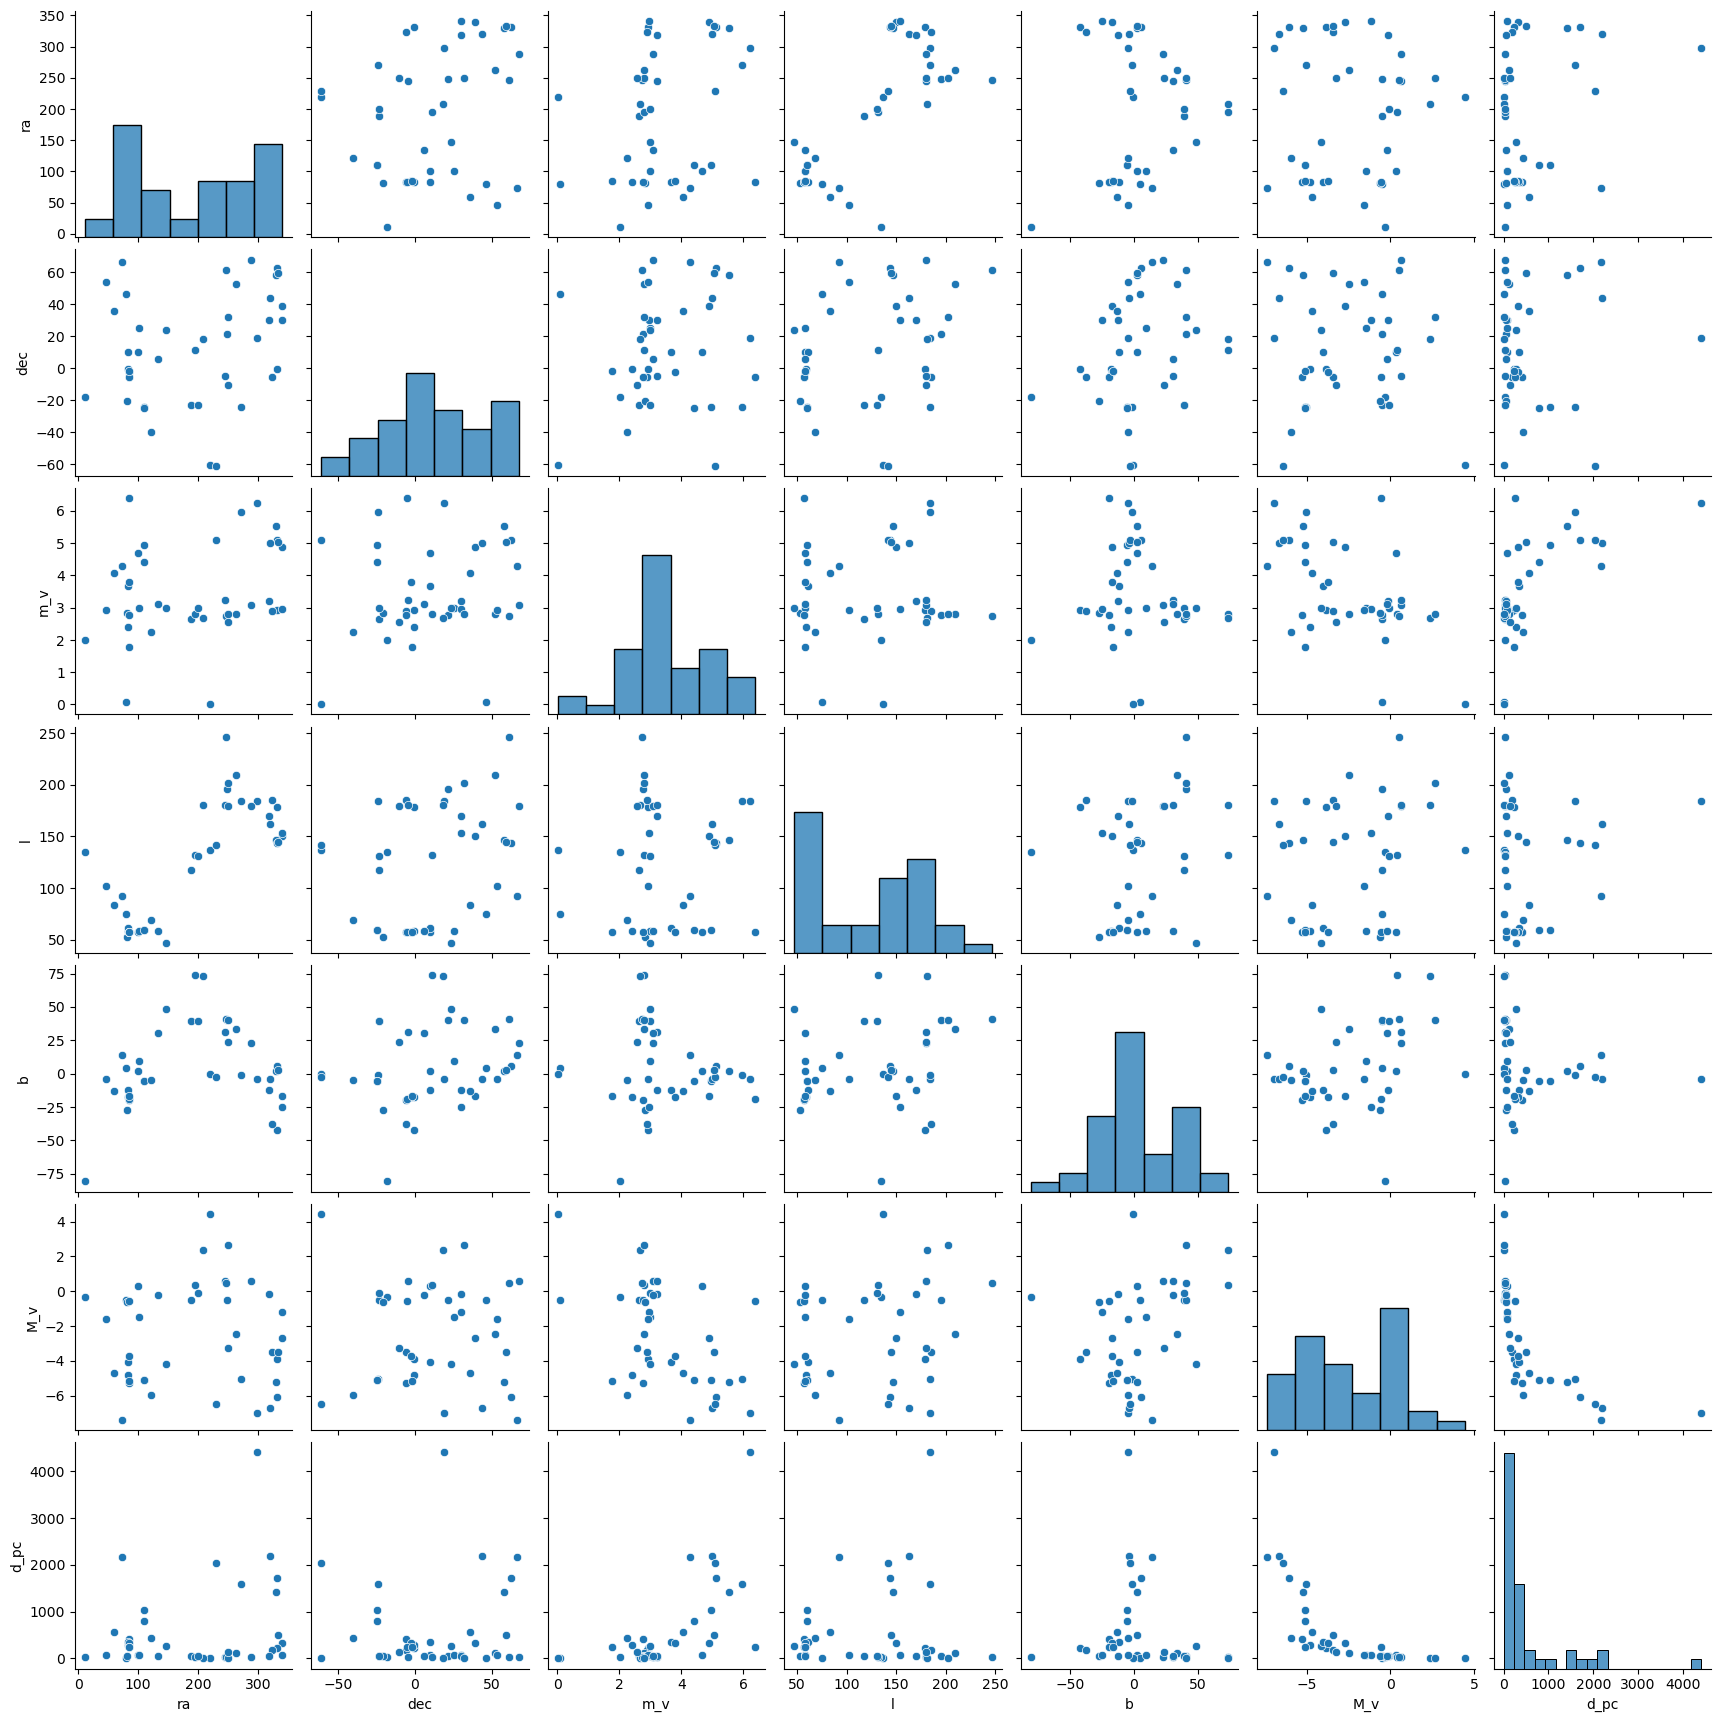

In [10]:
#pair Ploting 
sns.pairplot(df)
plt.show()

## Task 2 Plotting the Aitoff Projection:

In [12]:
# Generate galactic plane coordinates in ICRS
def gplane_RaDec():
    latitude = np.zeros(361)
    longitude = np.arange(361)
    galactic_plane = coord.SkyCoord(l=longitude * u.deg, b=latitude * u.deg, frame='galactic')
    return galactic_plane.transform_to('icrs')

In [13]:
# plot function for icrs
def plot_icrs(results, stars_icrs, gplane):
    # Create a new figure with a specific size
    fig = plt.figure(figsize=(12, 6))
    
    # Add a subplot with the Aitoff projection for spherical coordinates
    ax = fig.add_subplot(projection='aitoff')
    
    # Enable grid lines on the plot
    ax.grid(True)
    
    # Set the title of the plot
    ax.set_title("Stars in ICRS Coordinates with Galactic Plane", fontsize=12)

    # Iterate over the results (stars) and plot each star's coordinates
    for i, row in enumerate(results):
        # Get the right ascension (RA) and declination (Dec) for the star from the ICRS coordinates
        ra = stars_icrs.ra.wrap_at(180 * u.deg).radian[i]  # Wrap RA to handle the 360-degree wraparound
        dec = stars_icrs.dec.radian[i]  # Convert declination to radians

        # Get the spectral type and name of the star
        sp = row['sp_type']
        name = row['main_id']
        
        # Assign a color and marker based on the spectral type of the star
        color = 'red' if sp.startswith('O') else 'blue'  # Red for O-type stars, blue for others
        marker = 'o' if sp.startswith('O') else 'x'  # Circle marker for O-type stars, cross for others
        
        # Plot the star's position on the sky (RA, Dec) with the assigned color and marker
        ax.plot(ra, dec, marker=marker, color=color)
        
        # Annotate the plot with the star's name at its RA and Dec position
        ax.annotate(name, (ra, dec), fontsize=6, alpha=0.7)

    # Plot the Galactic plane as a dashed line
    ax.plot(gplane.ra.wrap_at(180 * u.deg).radian, gplane.dec.radian, 'k--', label='Galactic Plane')
    
    # Add a legend to the plot
    ax.legend()
    
    # Display the plot
    plt.show()


In [14]:
# plot function for galactic
def plot_galactic(results, stars_glctc):
    # Create a new figure with a specific size
    fig = plt.figure(figsize=(12, 6))
    
    # Add a subplot with the Aitoff projection for spherical coordinates
    ax = fig.add_subplot(projection='aitoff')
    
    # Enable grid lines on the plot
    ax.grid(True)
    
    # Set the title of the plot
    ax.set_title("Stars in Galactic Coordinates", fontsize=12)

    # Iterate over the results (stars) and plot each star's galactic coordinates
    for i, row in enumerate(results):
        # Get the galactic longitude (l) and latitude (b) for the star
        l = stars_glctc.l.wrap_at(180 * u.deg).radian[i]  # Wrap longitude to handle the 360-degree wraparound
        b = stars_glctc.b.radian[i]  # Convert latitude to radians

        # Get the spectral type and name of the star
        sp = row['sp_type']
        name = row['main_id']
        
        # Assign a color and marker based on the spectral type of the star
        color = 'red' if sp.startswith('O') else 'blue'  # Red for O-type stars, blue for others
        marker = 'o' if sp.startswith('O') else 'x'  # Circle marker for O-type stars, cross for others

        # Plot the star's position on the sky (galactic longitude and latitude) with the assigned color and marker
        ax.plot(l, b, marker=marker, color=color)
        
        # Annotate the plot with the star's name at its galactic coordinates
        ax.annotate(name, (l, b), fontsize=6, alpha=0.7)

    # Display the plot
    plt.show()


In [15]:
# Get Galactic Plane in ICRS
gplane_icrs = gplane_RaDec()

# Coordinates
stars_icrs = coord.SkyCoord(ra=df['ra'], dec=df['dec'], unit=(u.hourangle, u.deg), frame='icrs')
stars_glctc = stars_icrs.transform_to('galactic')

# Add Galactic coordinates to the DataFrame
df['l'] = stars_glctc.l.wrap_at(180 * u.deg).radian
df['b'] = stars_glctc.b.radian

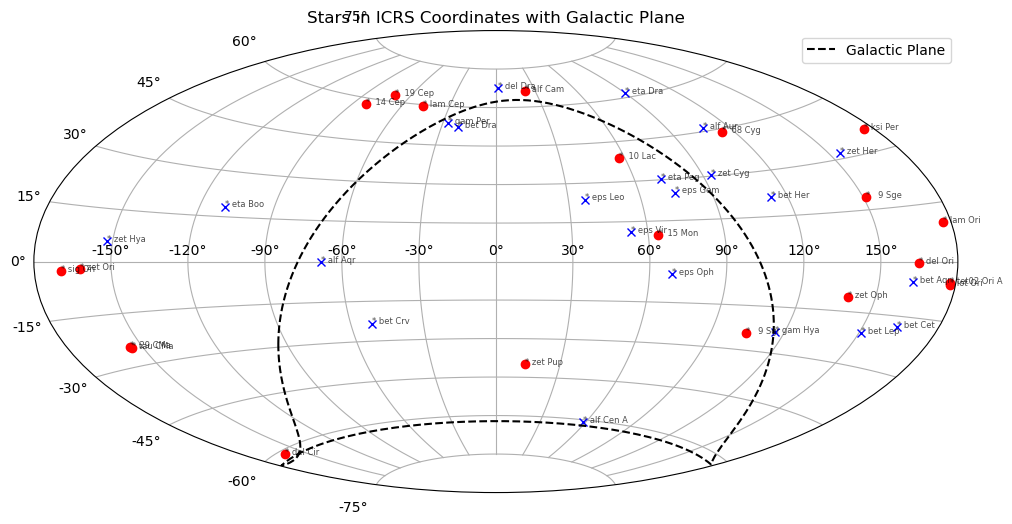

In [16]:
# Plotting icrs
plot_icrs(tap_result, stars_icrs, gplane_icrs)

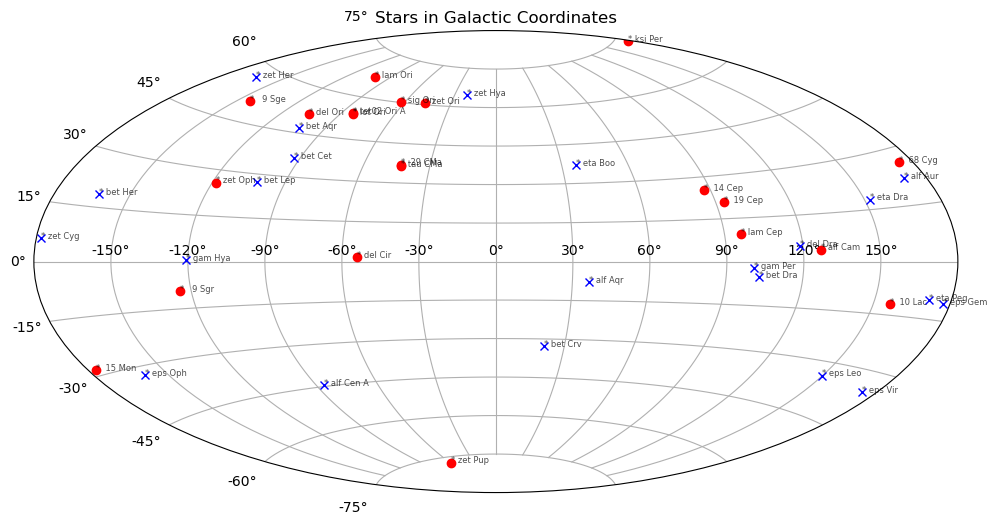

In [17]:
# Plotting galactic
plot_galactic(tap_result, stars_glctc)

## Task 3 Histogram Representation:

In [67]:
# b-histogram with spectral type filtering
def plot_b_histogram(df, stars_b, _class, bin_size=0.1, color='skyblue'):
    # Filter stars of the specified spectral type
    b_filtered = [
        b for (_, row), b in zip(df.iterrows(), stars_b)
        if str(row['sp_type']).startswith(_class)
    ]

    # Define bin edges using the provided bin size
    min_b = np.min(b_filtered)
    max_b = np.max(b_filtered)
    bins = np.arange(min_b, max_b + bin_size, bin_size)

    # Plot
    plt.figure(figsize=(10, 6))
    plt.hist(b_filtered, bins=bins, edgecolor='black', color=color)
    plt.title(f'Histogram of Galactic Latitude (b) for {_class}-type Stars\nBin Size = {bin_size}')
    plt.xlabel('Galactic Latitude b (radians)')
    plt.ylabel('Number of Stars')
    plt.grid(True, linestyle='--', alpha=0.6)
    plt.tight_layout()
    plt.show()


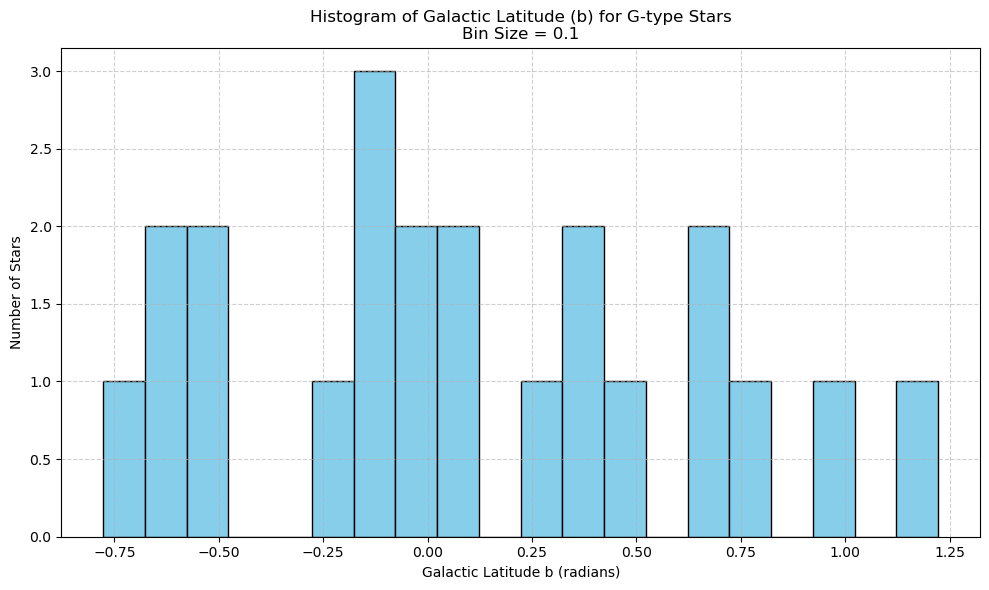

In [71]:
plot_b_histogram(df, df['b'], 'G')

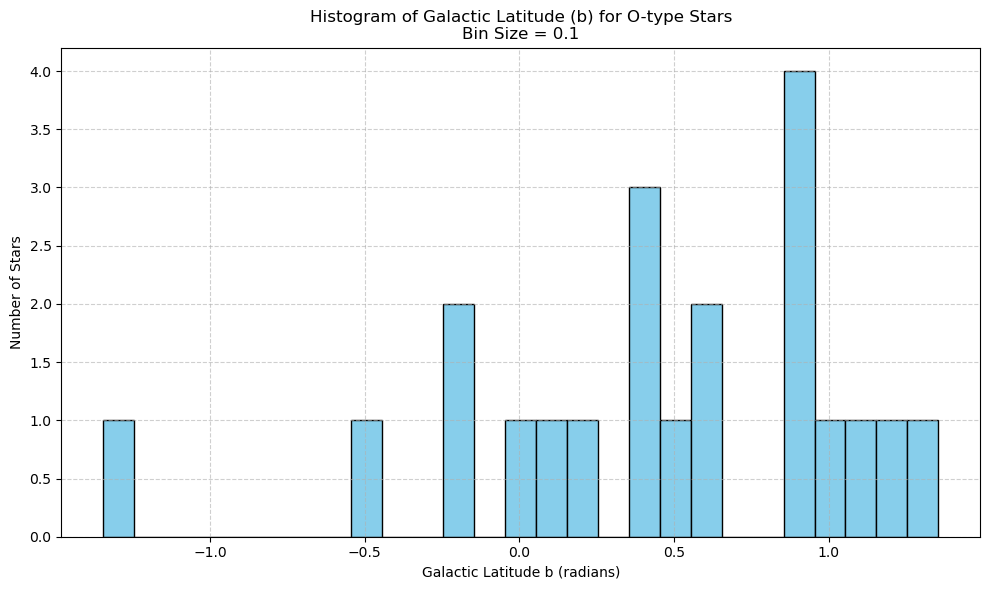

In [73]:
plot_b_histogram(df, df['b'], 'O')

## Task 4 Distance Modulus:

In [41]:
# Plotting Histogram of Star Distances from the Galactic Plane
def plot_gplane_hist(df, stars_b, _class, bins=20, color='skyblue'):
    # Compute perpendicular distances to the Galactic plane for matching spectral type
    d_plane = [
        row['d_pc'] * np.sin(b)
        for (_, row), b in zip(df.iterrows(), stars_b)
        if str(row['sp_type']).startswith(_class)
    ]

    # Plot histogram
    plt.figure(figsize=(10, 6))
    plt.hist(d_plane, bins=bins, color=color, edgecolor='black', label=f'{_class}-type stars')
    plt.xlabel('Distance from Galactic Plane (pc)')
    plt.ylabel('Frequency')
    plt.title(f'Histogram of {_class}-type Star Distances from Galactic Plane')
    plt.legend()
    plt.grid(True, linestyle='--', alpha=0.5)
    plt.tight_layout()
    plt.show()


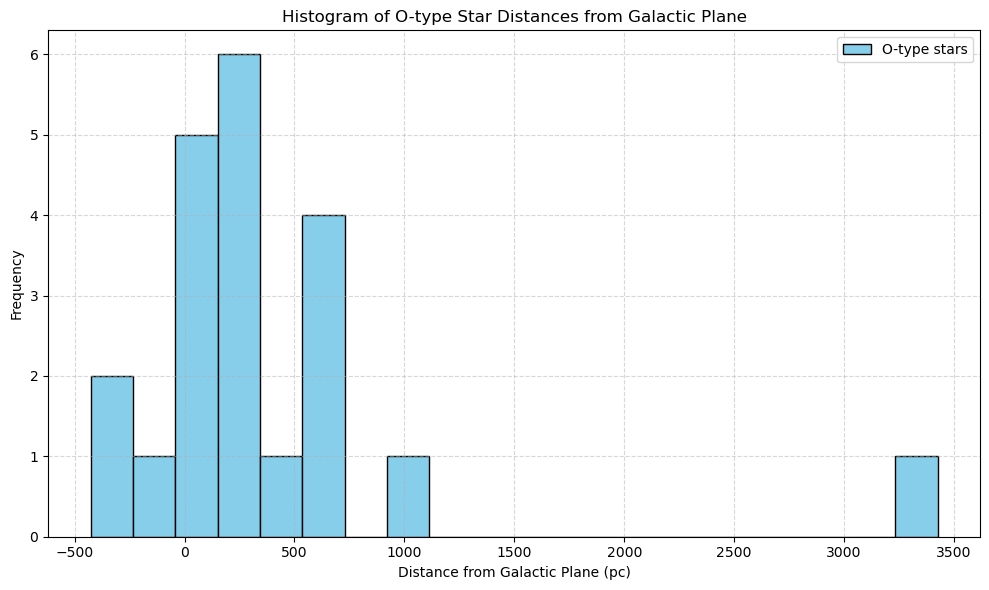

In [43]:
plot_gplane_hist(df, df['b'], 'O')

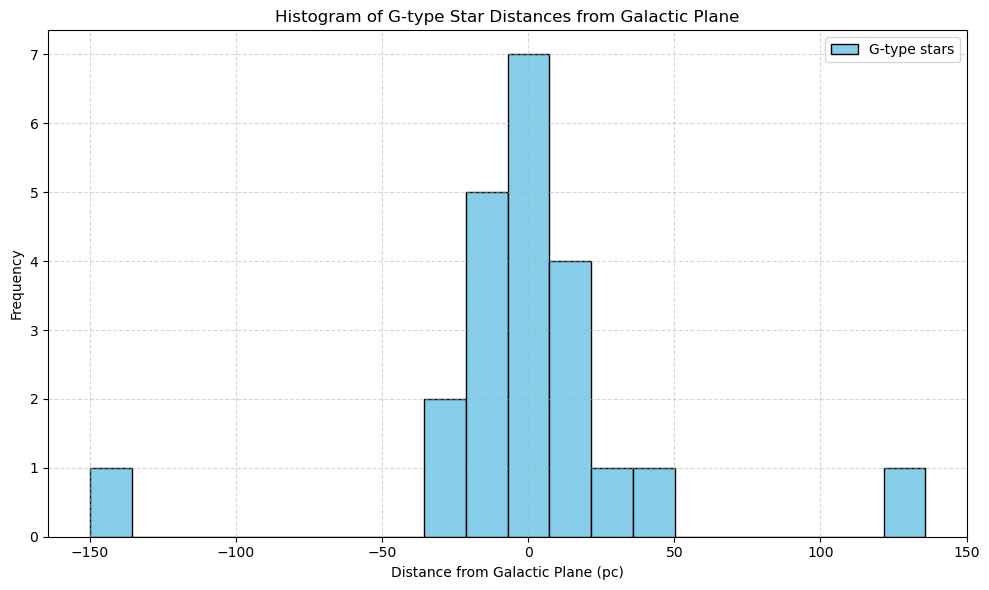

In [45]:
plot_gplane_hist(df, df['b'], 'G')

## Discussion:

The distribution of O-stars and G-stars in the galaxy can be influenced by several factors including their masses, luminosities, and lifetimes. O-type stars are typically much more massive and luminous than G type stars. They are also much shorter-lived, with main-sequence lifetimes on the order of millions of years compared to the billions of years for G-type stars.

The main-sequence lifetime ($\tau_{\text{ms}}$) of a star is given approximately by:

$$
\tau_{\text{ms}} \approx 10^{10} \left( \frac{M}{M_\odot} \frac{L_\odot}{L} \right)
$$

This formula shows that more massive stars have shorter main-sequence lifetimes.

The distribution of O-stars might differ from that of G-stars due to the following reasons:

1. **Lifespan and Lifetime Expectancy**: O-stars have much shorter lifespans compared to G-stars, leading to their concentration in regions of recent star formation.
2. **Star Formation Regions**: O-stars are typically formed in regions of active star formation such as spiral arms, while G-stars can form in a wider range of environments.
3. **Galactic Dynamics**: O-stars may have higher velocities due to their shorter lifetimes, leading to more dynamic trajectories.
4. **Feedback Effects**: O-stars contribute to feedback mechanisms through supernova explosions, influencing the conditions for future star formation.